# AutoregressiveModel

**Description:** AutoregressiveModel implemented in Keras to generate image.

**Objective:** The objective of this assignment is to practise using the TensorFlow machine learning framework
through implementing custom training modules and data reader modules for image generation on
the Chinese Calligraphy dataset using a convolutional neural network (CNN) based architecture.
Throughout the assignment, students will be guided to develop the CNN-based model step by
step and study how to build custom modules on TensorFlow and the effects of different model
configurations.

## Introduction

Image generation is one of the fundamental computer vision tasks, referring to the process of generating new images that are visually realistic and similar to real-world images. It is widely used in many applications, such as super resolution, photograph editing and 3D modelling. 

One approach to image generation is to use models that learn to predict the probability distribution of pixel values, given the values of all the previous pixels. These models generate images one pixel at a time, using the previously generated pixels to condition the generation of the next pixel.

### Setting environment

Note: You can only use the packages listed below !!!

In [1]:
import numpy as np
import math
import os
from PIL import Image
import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Getting the data


### Download dataset



In [2]:
# Download dataset from google drive
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt" -O calligraphy.zip && rm -rf /tmp/cookies.txt
! mkdir ./data && unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w7JVXz6U-NVDZxBf1oSAVjKdR4BJs1zI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1w7JVXz6U-NVDZxBf1oSAVjKdR4BJs1zI" -O calligraphy.zip && rm -rf /tmp/cookies.txt
! unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
! ls -l ./data

--2023-04-03 13:02:10--  https://docs.google.com/uc?export=download&confirm=t&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt
Resolving docs.google.com (docs.google.com)... 74.125.200.102, 74.125.200.113, 74.125.200.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lm3kn7mi1jql2m85vodokh9j3b1fcvvk/1680526875000/03446042882167617448/*/18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt?e=download&uuid=9ede8c3b-f1ba-474e-80a7-019960e3b198 [following]
--2023-04-03 13:02:11--  https://doc-08-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lm3kn7mi1jql2m85vodokh9j3b1fcvvk/1680526875000/03446042882167617448/*/18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt?e=download&uuid=9ede8c3b-f1ba-474e-80a7-019960e3b198
Resolving doc-08-9k-docs.googleusercontent.com (doc-08-9k-docs.googleusercontent.com)... 74.125.24.132, 2

### make dataset

In [3]:
# Model / data parameters
input_shape = (32, 32, 1)
batch_size = 32
data_dir = "./data/train_half"
data_name = "calligraphy"
test_dir = "/content/data/test_half"
!ls ./data/train_half | wc -l

42000


## Create layers for the requisite Layers for the model


In [4]:
# dataset class
def binarize(arr, img):

  #initialize threshold
  thresh=0.33

  #convert image to greyscale
  img=img.convert('L') 

  width,height=img.size

  #traverse through pixels 
  for x in range(width):
    for y in range(height):

      #if intensity less than threshold, assign white
      if arr[x][y] < thresh:
        arr[x][y] = 0

      #if intensity greater than threshold, assign black 
      else:
        arr[x][y] = 1

  return arr

class CalligraphySequence(tf.keras.utils.Sequence):

    def __init__(self,image_dir, batch_size, start = 0.0, last = 1.0,):
        ### [C1: Build init and len functions]
        # Your code here
        self.image_dir = image_dir
        size_of_dir = len(os.listdir(image_dir))
        self.files = os.listdir(image_dir)[int(size_of_dir* start): int(last*size_of_dir)]
        self.batch_size = batch_size

    def __len__(self): #counting the number of files in directory
        ### [C1: Build init and len functions]
        # Your code here
      count = 0
      for paths in os.listdir(self.image_dir): #os.listdir(director) is a list of files in directory and can access using listdir 
        if os.path.isfile(os.path.join(self.image_dir, paths)):
          count += 1
      return math.ceil(count / self.batch_size)

    def __getitem__(self, idx):
        ### [C2: Build getitem function]a
        # Round all pixel values less than 33% of the max 256 value to 0
        # anything above this value gets rounded up to 1 so that all values are either
        # 0 or 1
        # Your code here
        thres_val = 0.33 
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.files))
        file_y = self.files[low:high] #file names in batches 
        batches = list()
        for file_name in file_y:
          converted = Image.open(os.path.join(self.image_dir,file_name)).convert('L').resize((32, 32))
          batches.append(converted)
        normalized = []
        for image in batches:
          val = (np.array(image) - np.min(np.array(image)))/ (np.max(np.array(image)) - np.min(np.array(image)))
          normalized.append(val)
        images = list()
        for array in normalized:
          val = binarize(array, Image.fromarray(array))
          images.append(val)
        batch_y =  np.array(images)#binarize the normalized images  
        batch_y.resize((32, 32, 32, 1))
        return batch_y, batch_y
# final shape should be 1313 (32, 32, 32, 1) (32, 32, 32, 1)
train_ds = CalligraphySequence(data_dir, batch_size)
print(len(train_ds), train_ds[0][0].shape, train_ds[0][1].shape)

1313 (32, 32, 32, 1) (32, 32, 32, 1)


### Given function for conv2d / down_shift / right_shift / concat_elu
1. conv2d: 2d convolution layer using layers.Conv2D

2. down_shift: shift feature down in height dimension (by padding zero to the top and drop the bottom)

3. right_shift: shift feature right in width dimension

4. concat_elu: a nonlinearity layer (http://arxiv.org/abs/1603.05201)

The down_shift and right_shift functions are used to avoid information leaks in a causal network.


In [5]:
class Conv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[3, 3], stride=[1, 1], pad='SAME', nonlinearity=None, **kwargs):
        super().__init__()
        self.conv = layers.Conv2D(num_filters, filter_size, padding = pad, strides = stride, activation = nonlinearity, 
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))

    def call(self, x):
        return self.conv(x)

def down_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], step, input_shape[2], input_shape[3])), x[:, :input_shape[1] - step, :, :]], 1)

def right_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], input_shape[1], step, input_shape[3])), x[:, :, :input_shape[2] - step, :]], 2)

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape()) - 1
    out = tf.nn.elu(tf.concat([x, -x], axis))
    return out
inputs = (32, 32, 32, 1)
x = tf.random.normal(inputs)
y = tf.keras.layers.Conv2D(64, 5, padding="same", strides = 1, input_shape=inputs[1:])(x)
print(y.shape)

(32, 32, 32, 64)


### Gated Residual Block
The GatedResnet class applies gated residual connections to input tensors for feature extraction.

Please follow Section 4.2.3 to implement coding question.


In [6]:
class DownMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 3], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        ### [C4: Build DownMovedConv2d.]
        # Your code here
        self.conv2d = layers.Conv2D(num_filters, filter_size, stride,pad, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        self.filter_size = filter_size
    
    def call(self, x):
        ### [C4: Build DownMovedConv2d.]
        # Your code here
        padtop = self.filter_size[0] - 1
        padside = (self.filter_size[1] - 1) // 2
        paddings = tf.constant([[0,0], [padtop, 0], [padside, padside],[0,0]])
        x = tf.pad(x, paddings, 'CONSTANT')
        return self.conv2d(x)
class DownRightMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 2], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        ### [C3: Build DownRightMovedConv2d.]
        # Your code here
        self.conv2d = layers.Conv2D(num_filters, filter_size, stride,pad, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        self.filter_size = filter_size
    def call(self, x):
        ### [C3: Build DownRightMovedConv2d.]
        # Your code here
        padtop = self.filter_size[0] -1 
        padside = self.filter_size[1] - 1
        paddings = tf.constant([[0,0], [padtop, 0], [padside, 0], [0,0]])
        x = tf.pad(x, paddings, 'CONSTANT')
        return self.conv2d(x)

class TensorDense(layers.Layer):
    def __init__(self, num_units, nonlinearity=None, **kwargs):
        super().__init__()
        ### [C5: Build TensorDense.]
        # Your code here
        self.num_units = num_units
        self.dense = layers.Dense(units = num_units, kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
    def call(self, x):
        ### [C5: Build TensorDense.]
        # Your code here
        shapes = tf.shape(x)
        B = shapes[0]
        H = shapes[1]
        W = shapes[2]
        C = shapes[3]
        x = tf.reshape(x, [B*H*W, C])
        x = self.dense(x)
        x = tf.reshape(x, [B,H,W, self.num_units])
        return x

        


class GatedResnet(layers.Layer):
    def __init__(self, num_filters, nonlinearity=concat_elu, **kwargs):
        super().__init__()
        ### [C6: Build GatedResnet.]
        # Your code here
        self.num_filters = num_filters
        self.nonlinearity = nonlinearity
        self.nnLayer_1 = DownRightMovedConv2d(num_filters = self.num_filters)
        self.nnLayer_2 = DownRightMovedConv2d(num_filters = self.num_filters * 2)
    def call(self, x):
        ### [C6: Build GatedResnet.]
        # Your code here
        input_shape = tf.shape(x)
        C = input_shape[3]
      #make residual
        residual_1 = x
        x = self.nonlinearity(x) #nonlinearity activation session 
        x = self.nnLayer_1(x)
        x = self.nonlinearity(x)
        x = self.nnLayer_2(x)
        F, G= tf.split(x, [C, C], axis = 3)
        G = tf.keras.activations.sigmoid(G)
        F = tf.math.multiply(F, G) #should be added to tensor flow with residual
        return tf.math.add(F, residual_1) #returns the shape of (B,H,W,C_in)

### Main AutoregressiveModel

In [7]:
class AutoregressiveModel(layers.Layer):
    def __init__(self, n_resnet=5, n_filters=256, n_block=12, n_output=10, **kwargs):
        super().__init__()
        self.n_resnet = n_resnet #n
        self.n_filters = n_filters #n^filters
        self.n_block = n_block #m
        self.n_output = n_output#n^output
        # init all network layers
        self.down_moved_conv2d = DownMovedConv2d(num_filters=self.n_filters, filter_size=[1, 3])
        self.down_right_moved_conv2d = DownRightMovedConv2d(num_filters=self.n_filters, filter_size=[2, 1])
        ### [C7: Build AutoregressiveModel.]
        # Your code here3
        self.out_dense = TensorDense(num_units = self.n_output)
        self.ul_list_gated_resnet = [] #gatedresnet n
        self.ul_list_dense_layer = []#networkblock m 
        for i in range(n_block): #M times 
          gatedresnetlist = []
          for j in range(n_resnet):   #N times 
            gatedresnetlist.append(GatedResnet(num_filters = n_filters))
          self.ul_list_dense_layer.append(TensorDense(num_units = n_filters)) 
          self.ul_list_gated_resnet.append(gatedresnetlist) #M x N object

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        x = down_move(self.down_moved_conv2d(inputs)) + right_move(self.down_right_moved_conv2d(inputs)) #tensorsum (B,H,C, N^filter)
        ### [C7: Build AutoregressiveModel.]
        # Your code here
        for i in range(self.n_block):
          for j in range(self.n_resnet):
             x = self.ul_list_gated_resnet[i][j](x)
          x = self.ul_list_dense_layer[i](x)
        x = tf.keras.activations.elu(x)
        x = self.out_dense(x)
        return x

In [8]:
#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Build the model based on the original paper


In [9]:
## Build the model based on the original paper
inputs = keras.Input(shape=input_shape, dtype=tf.float32)
x = AutoregressiveModel(n_resnet=6, n_filters=64, n_block=6, n_output=10)(inputs)
out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
pixel_cnn.summary()
### [C11: Model training and log reporting]
# you can use keras.optimizers.Adam here to define "adam"
# compile your model and make a summary on its architecture
# Your code here
adam = keras.optimizers.Adam(learning_rate = 0.0001,beta_1=0.95, beta_2=0.9995, epsilon=1e-6, use_ema=True, ema_momentum=0.9995 )
pixel_cnn.compile(
    optimizer=adam,
     loss="binary_crossentropy",
    metrics=["accuracy"],
)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 autoregressive_model (Autor  (None, 32, 32, 10)       3571914   
 egressiveModel)                                                 
                                                                 
 conv2d_75 (Conv2D)          (None, 32, 32, 1)         11        
                                                                 
Total params: 3,571,925
Trainable params: 3,571,925
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                    

In [10]:
### [C8: Load the pretrained weights]
# Your code here
model_weight = pixel_cnn.load_weights(filepath = "/content/drive/MyDrive/pixel_cnn_e5.h5")
pixel_cnn.summary()
test_dir = "/content/data/test_half"
train_ds = CalligraphySequence(data_dir, batch_size, start = 0.0, last = 0.8)
val_ds = CalligraphySequence(data_dir, batch_size, start = 0.8, last = 1.0)
test_ds = CalligraphySequence(image_dir = test_dir, batch_size = batch_size)
call_backs =keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/frequency", save_weights_only = True, monitor = 'val_accuracy',mode = 'max', save_best_only = True),

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 autoregressive_model (Autor  (None, 32, 32, 10)       3571914   
 egressiveModel)                                                 
                                                                 
 conv2d_75 (Conv2D)          (None, 32, 32, 1)         11        
                                                                 
Total params: 3,571,925
Trainable params: 3,571,925
Non-trainable params: 0
_________________________________________________________________


In [ ]:

### [C11: Model training and log reporting]
# you can use model.fit here
# Your code here
#pixel_cnn.fit(x = train_ds, validation_data = val_ds, epochs = epoch, verbose = 1, batch_size = 32, callbacks = call_backs, use_multiprocessing = True, workers = 4)
pixel_cnn.fit(x = train_ds, validation_data = val_ds, epochs = 10, batch_size = 32)

Epoch 1/10
 833/1313 [==================>...........] - ETA: 30s - loss: 0.1498 - accuracy: 0.9382

In [ ]:
# save weights
pixel_cnn.save_weights('pixel_cnn_e15.h5')

## Demonstration

The AutoregressiveModel cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.

100%|██████████| 32/32 [01:06<00:00,  2.07s/it]


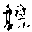

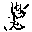

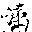

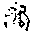

In [ ]:
from IPython.display import Image, display

# Create an empty array of pixels.
batch =  10 # you may want to change this parameter 
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            ### [C9: Qualitative Evaluation] 
            # Your code here
            # 1. Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel. You can use model.predict function to get predict value for each pixel.
            y_pred = pixel_cnn.predict(pixels, verbose = 0)
            # 2. Use the probabilities to pick pixel values and append the values to the image
            # frame. you can use tf.math.ceil to achieve the 0.5 threshold.
            y_pred = y_pred[:,row, col, channel]
            pixels[:, row, col, channel] = np.random.binomial(1, y_pred)
def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))

## Quantitative Evaluation



In [ ]:
### [C10: Quantitative Evaluation]
# Your code here
pixel_cnn.evaluate(test_ds)

329/329 [==============================] - 16s 35ms/step - loss: 0.1851 - accuracy: 0.9233


[0.1850622445344925, 0.9233470559120178]